### ***INTRODUCTORY NOTE :*** This is a notebook that analyzes an article by **[Biomass Magazine](http://biomassmagazine.com/)** on the upcoming projects, ongoing projects and current status of the revenues of *Covanta.*

#### Please note that this notebook uses a plotly chart for showing word-frequency distribution. Plotly charts are not supported by GitHub's default view. To view the plot, visit [this notebook](https://colab.research.google.com/drive/1FSrpL-zMaSKGniEjv7n_pgaYS6jDJ7JY?usp=sharing).

In [38]:
import requests
import nltk
nltk.download('state_union')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import state_union
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib as ml
import matplotlib.pyplot as plt
%matplotlib inline
ml.style.use('ggplot')
import plotly.graph_objects as go
import random
from wordcloud import WordCloud
from html.parser import HTMLParser
import urllib.request
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import operator

[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Extracting the Article 
#### Article being worked on : [BIOMASS Magazine : Covanta discusses progress with energy-from-waste projects](http://biomassmagazine.com/articles/16574/covanta-discusses-progress-with-energy-from-waste-projects)

In [39]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.162 Safari/537.36'}
url = 'http://biomassmagazine.com/articles/16574/covanta-discusses-progress-with-energy-from-waste-projects'
webpage = requests.get(url,headers=headers).text
webpage

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">\n<html xml:lang="en" xmlns="http://www.w3.org/1999/xhtml" lang="en">\n<head>\n<title>Covanta discusses progress with energy-from-waste projects  | Biomassmagazine.com</title>\n\n<meta name="og:description" content="Covanta released third quarter financial results on Oct. 24, reporting increased revenue, net income and adjusted EBITDA. During an earnings call, Covanta officials briefly discussed progress with the company\'s U.K. energy-from-waste projects.  " /> \n<meta name="description" content="Covanta released third quarter financial results on Oct. 24, reporting increased revenue, net income and adjusted EBITDA. During an earnings call, Covanta officials briefly discussed progress with the company\'s U.K. energy-from-waste projects.  " /> \n<meta name="keywords" content="Covanta discusses progress with energy-from-waste projects  | Biomassmagazine.com,biomass power and the

In [40]:
# Scraping the text
soup = BeautifulSoup(webpage,'lxml')
paragraphs = []
article_text = soup.find_all('p')
for para in article_text:
  paragraphs.append(para.text.strip())
article = " ".join(paragraphs)
# Just a check to see if entire article got scraped
article[-15:-2]

' $122 million'

### TEXT PREPROCESSING
1. Tokenizing : 
  1. WORD TOKENIZING
      - Regex tokenizing
      - Word tokenizing
  2. SENTENCE TOKENIZING
      - Punkt tokenizing

In [41]:
train_text = state_union.raw('2006-GWBush.txt')
tok_reg,tok_w,tok_p = sorted(nltk.tokenize.RegexpTokenizer('\w+').tokenize(article)),sorted(nltk.tokenize.word_tokenize(article)),nltk.tokenize.punkt.PunktSentenceTokenizer(train_text=train_text).tokenize(article)
sent_five = "\n\n".join(tok_p[:5])
print("REGEXP TOKENIZER : \nFirst 5 words : {}\nLength = {}\n\nWORD TOKENIZER : \nFirst 5 words : {}\nLength = {}\n\nPUNKT SENTENCE TOKENIZER : \nFirst 5 sentences : \n{}\n\nLength = {}".format(tok_reg[:5],len(tok_reg),tok_w[:5],len(tok_w),sent_five,len(tok_p)))

REGEXP TOKENIZER : 
First 5 words : ['12', '122', '125', '14', '19']
Length = 482

WORD TOKENIZER : 
First 5 words : ['$', '$', '$', '$', '$']
Length = 543

PUNKT SENTENCE TOKENIZER : 
First 5 sentences : 
Covanta Holding Corp.

released third quarter financial results on Oct.

24, reporting increased revenue, net income and adjusted EBITDA.

During an earnings call the following day, Covanta officials briefly discussed progress with its U.K.

energy-from-waste projects and said the company is considering the development of energy-from-waste projects in other regions.

Length = 26


Notice that the number of words resulting from Word tokenizer is higher than that by Regexp tokenizer. Let's find out which words are extra.

In [42]:
no_match,punctuated,final = [],[],[]
for word in tok_w:
  if word not in tok_reg and word not in string.punctuation and word not in ["''",'``',',','"']:
    # print(word)
    no_match.append(word)
# On printing out the extra words during the test run, we found the maximum of them to be punctuations, as word tokenizer doesn't filter out punctuations.
no_match = no_match[:-7]    # As the last 7 elements were unwanted characters
no_match
# Append the filtered out extra words to tok_reg
tok_reg.extend(no_match)
print("New length of final list of tokenized words = {}".format(len(tok_reg)))

New length of final list of tokenized words = 496


2. Removing stopwords
### WHY IS IT NECESSARY TO REMOVE STOPWORDS AS AN INTIAL STEP OF TEXT PREPROCESSING ?
#### Let us see through an example
#### --> Finding the most frequent words in tok_p before removing the stopwords

In [43]:
# For ease of analysis, all characters are turned to lowercase
final_text = ("".join(tok_p)).lower()
final_text
freq,w = [],[]
# Creating the model
cv = CountVectorizer()
matrix = cv.fit_transform(tok_p)
# Extracting the count sparse matrix
dense_mat = np.array(matrix.todense())
# Extract each word in the text and its corresponding count(frequency) in the text.
count = list(zip(cv.get_feature_names(),np.asarray(dense_mat.sum(axis=0)).ravel()))
for tup in count:
  freq.append(tup[1])
freq = sorted(freq,reverse=True)
# Extracting the top 5 words
for f in freq[:5]:
  for elem in count:
    if elem[1] == f:
      w.append(elem[0])
      break
    else:
      continue
print("Top 5 words before removing stopwords :")
print(",".join(w))

Top 5 words before removing stopwords :
the,and,in,in,projects


Among the top 5 most frequent words, we see that *4 of them are either article words or prepositions*. 

Now, suppose you were using this piece of text to analyse the sentiment or find out the meaning/purpose of the text. Since this text has an ***abundance*** of such words( **these are what we know as stopwords** ), they won't enhance the performance of our algorithm. On the contrary, ***they are an unwanted hindrance.***

Hence we get rid of stopwords.

#### --> Finding the most frequent words in tok_p after removing the stopwords

In [44]:
# Setting up
stopwords,words_new = nltk.corpus.stopwords.words('english'),[]
# Filtering
for word in tok_reg:
    if word not in stopwords:
        words_new.append(word)
# len(words_new)

# Top 5 words now
freq2,w2 = [],[]
# Creating the model
cv2 = CountVectorizer()
matrix2 = cv2.fit_transform(words_new)
# Extracting the count sparse matrix
dense_mat2 = np.array(matrix2.todense())
# Extract each word in the text and its corresponding count(frequency) in the text.
count2 = list(zip(cv2.get_feature_names(),np.asarray(dense_mat2.sum(axis=0)).ravel()))
for tup in count2:
  freq2.append(tup[1])
freq2 = sorted(freq2,reverse=True)
# Extracting the top 5 words
for f in freq2[:5]:
  for elem in count2:
    if elem[1] == f:
      w2.append(elem[0])
      break
    else:
      continue
print("Top 5 words after removing stopwords :")
print(",".join(w2))

Top 5 words after removing stopwords :
million,projects,energy,energy,energy


The drastic change in the top 5 most common words is noticeable. They now make more sense and highlight a slight meaning in them( ***more energy and industry related words*** )

In [45]:
print("Currrent length of extracted words = {}".format(len(words_new)))

Currrent length of extracted words = 325


3. Stemming and Lemmatization
### WHAT IS LEMMATIZATION AND HOW DIFFERENT IS IT FROM STEMMING ?
OVERVIEW : If you look at the words 'shoe' and 'shoes', they will mean the same to you. But in Natural Language Processing, they are different. 'shoe' is a root word, whereas 'shoes' is one of its stems.

Think of it like a mushroom. 'shoe' is the mushroom head, and the ending 's' of 'shoes' lies in the mushroom stem.

" *These syntactic differences between word forms are called inflections, and they create challenges for query understanding. In **the example of 'shoe' and 'shoes'**, we probably want to treat the two forms **identically**. But we **wouldn’t want to do the same for the words 'logistic' and 'logistics'**, which **mean very different things** despite their **apparent similarity**. Nor would we want to equate the words universe and university, even though both words derive from the same Latin root.*

***Stemming and lemmatization*** *are two approaches to handle such* ***inflections.***"

### WHAT IS STEMMING ?

When we stem a word, we chop off its inflections and keep what hopefully represents the main essence of the word. E.g : ***'apple'*** and ***'apples'*** down to ***'appl'***, and it stems ***'berry'*** and ***'berries'*** to ***'berri'***.

**DISADVANTAGE :** Stemming algorithms sometimes *remove too little or too much*. For example, ***PorterStemmer([Read the docs](https://www.nltk.org/api/nltk.stem.html?highlight=porterstemmer#nltk.stem.porter.PorterStemmer))*** stems both ***'meanness'*** and ***'meaning'*** to ***'mean'***, creating a false equivalence. On the other hand, PorterStemmer stems goose to goos and geese to gees, when those two words should be equivalent.

### WHY IS LEMMATIZATION MORE ACCEPTABLE ?

Lemmatization does not simply chop off inflections, but instead ***relies on a lexical knowledge base like [WordNet](https://wordnet.princeton.edu/) to obtain the correct base forms of words.*** E.g : WordNet lemmatizes ***'geese'*** to ***'goose'*** and lemmatizes ***'meanness'*** and ***'meaning'*** to themselves.

**DISADVANTAGE :** 
1. PorterStemmer stems both ***'happiness'*** and ***'happy'*** to ***'happi'***, while WordNet lemmatizes the two words to themselves. 

2. The WordNet lemmatizer also requires specifying the word’s part of speech — *otherwise, it assumes the word is a noun.* 

3. Finally, lemmatization cannot handle unknown words. E.g : PorterStemmer stems both ***'iphone'*** and ***'iphones'*** to ***'iphon'***, while WordNet lemmatizes both words to themselves.

### **In general, lemmatization offers better precision than stemming, but at the expense of [recall](https://en.wikipedia.org/wiki/Precision_and_recall).**

In [46]:
'''A. Stemming
    1. PorterStemmer
    2. SnowballStemmer
B. Lemmatizing
  1. WordNetLemmatizer'''

# Stemming 1
ps = nltk.stem.PorterStemmer()
words_pstemmed = [ps.stem(w) for w in words_new]
# Removing identical root words
words_pstemmed_unq = list(set(words_pstemmed))

# Stemming 2
sbs = nltk.stem.snowball.SnowballStemmer('english')   # SnowballStemmer needs a language to be mentioned
words_sbstemmed = [sbs.stem(w) for w in words_new]
# Removing identical root words
words_sbstemmed_unq = list(set(words_sbstemmed))

# Lemmatization (WordNet lemmatization)
wnl = nltk.stem.WordNetLemmatizer()
words_lem = [wnl.lemmatize(w) for w in words_new]
# Removing identical root words
words_lem_unq = list(set(words_lem))

print("No. of unique root words after Port stemming = {}\n\nNo. of unique root words after Snowball stemming = {}\n\nNo. of unique root words after WordNet lemmatization = {}".format(len(words_pstemmed_unq),len(words_sbstemmed_unq),len(words_lem_unq)))

No. of unique root words after Port stemming = 190

No. of unique root words after Snowball stemming = 190

No. of unique root words after WordNet lemmatization = 205


#### We observe that the number of unique root words obtained as a result of lemmatization is more than the number of unique root words obtained as a result of stemming.
#### This shows the diversity and better performing ability of ***lemmatization***.


4. Finding the frequency distribution of the top 20 words

In [47]:
freq_words = nltk.FreqDist(words_lem)
freq_words_sorted = sorted(freq_words.items(), key = operator.itemgetter(1))
# Extracting the top 20 most frequent words and their frequency values
freq_words_top20 = freq_words_sorted[-20:]
freq_top20 = [val[1] for val in freq_words_top20]
freq_top20n = [val[0] for val in freq_words_top20]
for i in range(len(freq_words_top20)):
  print("{}. WORD = {} || FREQUENCY OF OCCURRENNCE = {}\n".format(i+1,freq_words_top20[i][0],freq_words_top20[i][1]))
# Plotting the frequencies
fig = go.Figure([go.Bar(x=freq_top20n, y=freq_top20)])
fig.update_layout(title_text='TOP 20 MOST USED ROOT WORDS IN THE ARTICLE')
fig.update_traces(marker_color='green')
fig.show()

1. WORD = close || FREQUENCY OF OCCURRENNCE = 3

2. WORD = reported || FREQUENCY OF OCCURRENNCE = 3

3. WORD = U.K. || FREQUENCY OF OCCURRENNCE = 3

4. WORD = energy-from-waste || FREQUENCY OF OCCURRENNCE = 3

5. WORD = U || FREQUENCY OF OCCURRENNCE = 4

6. WORD = development || FREQUENCY OF OCCURRENNCE = 4

7. WORD = financial || FREQUENCY OF OCCURRENNCE = 4

8. WORD = last || FREQUENCY OF OCCURRENNCE = 4

9. WORD = Jones || FREQUENCY OF OCCURRENNCE = 5

10. WORD = energy || FREQUENCY OF OCCURRENNCE = 5

11. WORD = said || FREQUENCY OF OCCURRENNCE = 5

12. WORD = third || FREQUENCY OF OCCURRENNCE = 5

13. WORD = waste || FREQUENCY OF OCCURRENNCE = 5

14. WORD = well || FREQUENCY OF OCCURRENNCE = 5

15. WORD = Covanta || FREQUENCY OF OCCURRENNCE = 6

16. WORD = revenue || FREQUENCY OF OCCURRENNCE = 6

17. WORD = quarter || FREQUENCY OF OCCURRENNCE = 7

18. WORD = year || FREQUENCY OF OCCURRENNCE = 8

19. WORD = million || FREQUENCY OF OCCURRENNCE = 13

20. WORD = project || FREQUENCY O

5. Finding out the words that have been imparted the highest weightage.
 
#### The best method for the above mentioned Analysis is building a WordCloud
1. WordCloud with 100 words
2. WordCloud with 200 words
3. WordCloud with 300 words

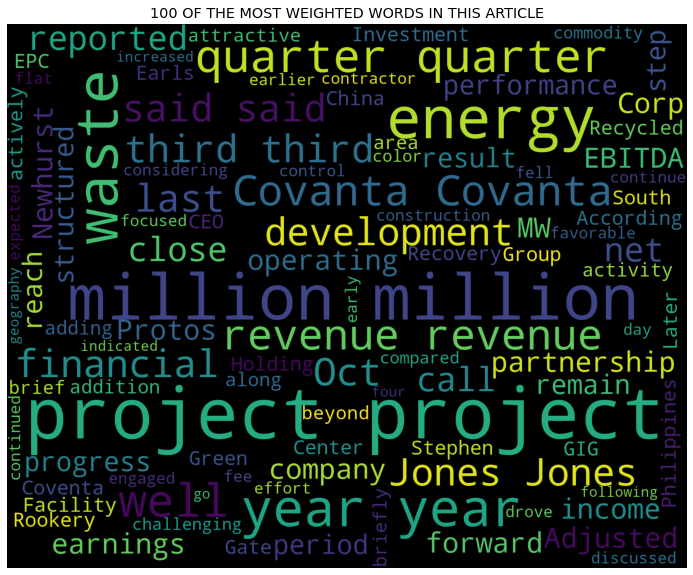

In [48]:
# Converting the finalized list of lemmatized words into one string
final = " ".join(words_lem)
# Wordcloud 1
plt.figure(figsize=(20,10))
wc_100 = WordCloud(
    background_color = 'black',
    max_words = 100,
    width = 1500,
    height = 1200
).generate(final)
# Plot
plt.imshow(wc_100)
plt.title('100 OF THE MOST WEIGHTED WORDS IN THIS ARTICLE')
plt.axis('off')
plt.show()

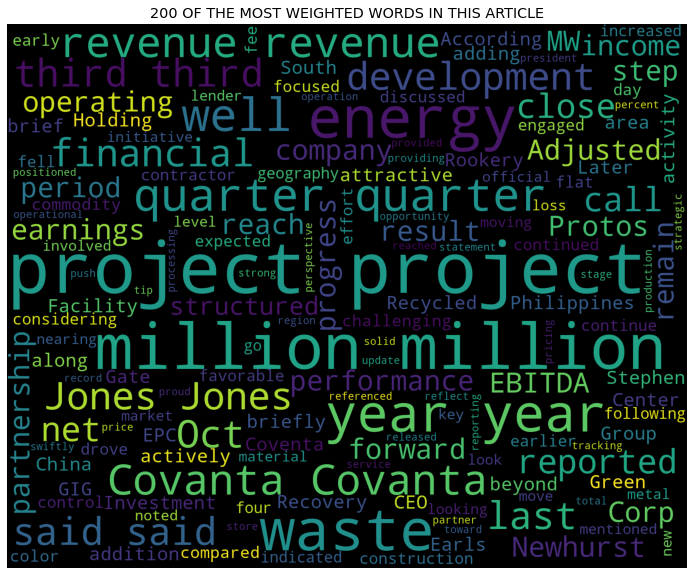

In [49]:
# Wordcloud 2
plt.figure(figsize=(20,10))
wc_200 = WordCloud(
    background_color = 'black',
    max_words = 200,
    width = 1500,
    height = 1200
).generate(final)
# Plot
plt.imshow(wc_200)
plt.title('200 OF THE MOST WEIGHTED WORDS IN THIS ARTICLE')
plt.axis('off')
plt.show()

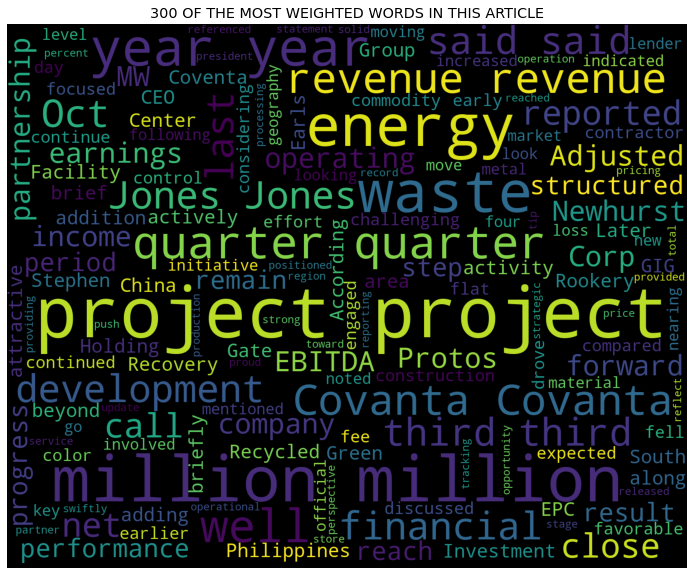

In [50]:
# Wordcloud 3
plt.figure(figsize=(20,10))
wc_300 = WordCloud(
    background_color = 'black',
    max_words = 300,
    width = 1500,
    height = 1200
).generate(final)
# Plot
plt.imshow(wc_300)
plt.title('300 OF THE MOST WEIGHTED WORDS IN THIS ARTICLE')
plt.axis('off')
plt.show()

### From the above plots, we may conclude :
1. We can say that Covanta makes fairly huge revenues, ammounting to millions of dollars
2. Its major domains of work include : a) Energy and b) Waste, which is true, as Covanta is a company dealing in waste management.
3. This article foucuses on Covanta's high revenue / upcoming / ongoing projects.
4. Most statements in this articles are excerpts from Stephen Jones, who is the president and CEO of Covanta.
5. We find names of places like Protos, Newhurst and China. This throws light on the decided locations of ongoing projects(that are nearing financial close) as well as the upcoming ones.

6. Last step : Analyzing the sentiment of each sentence in this article using NLTK's inbuilt sentiment analyzer class (here, we'll make use of VADER)

**WHAT IS VADER ?** : ***V***alence ***A***ware ***D***ictionary for s***E***ntiment ***R***easoning, or ***Vader***, is an NLP algorithm that blended a *sentiment lexicon* approach as well as grammatical rules and syntactical conventions for expressing sentiment polarity and intensity.

*WHAT IS MEANT BY SENTIMENT LEXICON ?* --> The lexicon approach means that this ***algorithm constructed a dictionary that contains a comprehensive list of sentiment features***. This lexical dictionary does not only contain words, but also *phrases (such as “bad ass” and “the bomb”), emoticons (such as “:-)”) and sentiment-laden acronyms (such as “ROFL” and “WTF”)*. All the lexical features were rated for the polarity and intensity on a scale from ***“-4: Extremely Negative” to “+4 Extremely Positive”*** by 10 independent human raters. The average score is then used as the sentiment indicator for each lexical feature in the dictionary. 

#### E.g : 
In Vader, the word ***“okay”*** has a positive rating of ***0.9***, ***“good”*** is ***1.9*** and ***“great”*** is ***3.1***, whereas ***“horrible”*** is ***-2.5***, the ***frowning emoticon “:(“*** is ***-2.2***, and ***“sucks”*** is ***-1.5***. Vader’s lexicon dictionary contains around 7,500 sentiment features in total and any word not listed in the dictionary will be scored as “0: Neutral”.

In [52]:
sent_an = SentimentIntensityAnalyzer()
for sentence in tok_p:
  print("SENTENCE : ",sentence)
  pol_scores = sent_an.polarity_scores(sentence)
  for i in sorted(pol_scores):
    print('{0}: {1}, '.format(i, pol_scores[i]), end='')
  print("\n\n")

SENTENCE :  Covanta Holding Corp.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 


SENTENCE :  released third quarter financial results on Oct.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 


SENTENCE :  24, reporting increased revenue, net income and adjusted EBITDA.
compound: 0.2732, neg: 0.0, neu: 0.792, pos: 0.208, 


SENTENCE :  During an earnings call the following day, Covanta officials briefly discussed progress with its U.K.
compound: 0.4215, neg: 0.0, neu: 0.833, pos: 0.167, 


SENTENCE :  energy-from-waste projects and said the company is considering the development of energy-from-waste projects in other regions.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 


SENTENCE :  "Our third quarter results reflect solid operations and a strong waste market, which drove favorable year-over-year performance," said Stephen Jones, president and CEO of Covanta, in a statement.
compound: 0.6369, neg: 0.085, neu: 0.671, pos: 0.244, 


SENTENCE :  "Waste processing and energy production are 

### The major portion of the article is neutral or positive, showing that this article is conveying some information or positive assertion.